# Jax implementation of the Gaussian model

In [ ]:
%load_ext autoreload
%autoreload 2
import site, sys, os, time
site.addsitedir('..')
from jax.config import config

#config.update("jax_enable_x64", True)

In [ ]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
import jax
from jax import random

plt.rcParams["figure.figsize"]=6,6

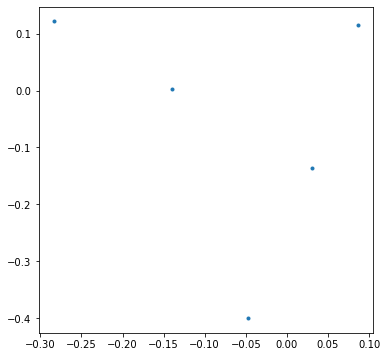

In [ ]:
npt=5
pts00=jnp.array(np.random.randn(npt,2))
pts00=pts00/(jnp.max(abs(pts00))*2.5)
plt.plot(pts00[:,0], pts00[:,1],'.')

In [ ]:
#### size of image. memory usage scales with N^2 of this.
boxsz=sz=128

#### precompute Fourier indices 
idx=jnp.indices((boxsz,boxsz))-boxsz//2
idx=jnp.fft.ifftshift(idx)
idx=idx[:,:,:boxsz//2+1]
idxft=(idx/sz).astype(jnp.float32)[:, None, :,:]



#### Variable amplitude

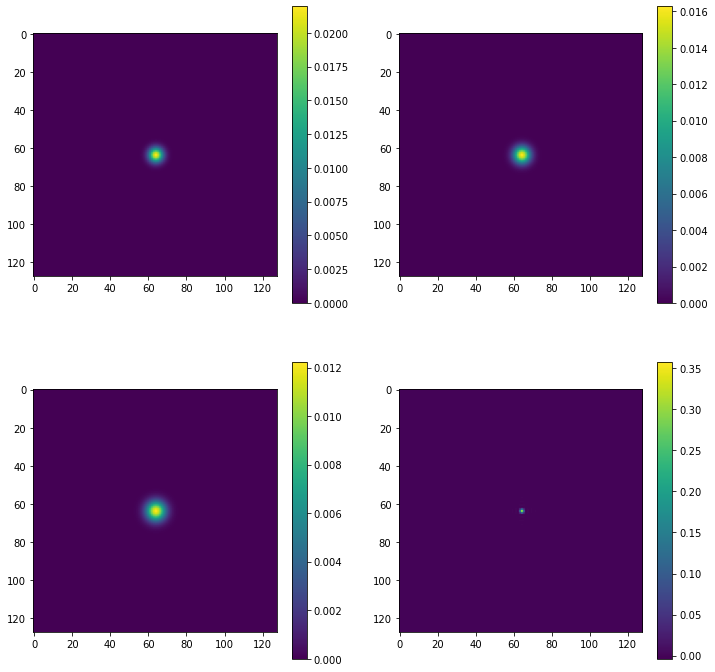

In [ ]:
# EDIT Bogdan: no sqrt so that we can split the amp calculation in x and y parts
#rrft=jnp.sqrt(jnp.sum(idx**2, axis=0)).astype(jnp.float32)## batch, npts, x-y
rrft=jnp.sum(idx**2, axis=0).astype(jnp.float32)## batch, npts, x-y

#amp=jnp.exp(-rrft*.1)

sig = 0.01
sigs = sig + np.random.randn(npt)*0.005                        
amp = jnp.array([jnp.exp(-rrft*s) for s in sigs])

plt.rcParams["figure.figsize"]=12,12
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(jnp.fft.fftshift(jnp.fft.irfft2(amp[i])))
    plt.colorbar()
plt.rcParams["figure.figsize"]=6,6

In [ ]:
pts00[None,:,:].shape

In [ ]:
print(idxft.shape)

In [ ]:
0.31622777**2

### Initial TensorFlow implementation, translated to JAX

pgauss_real.shape = (1, 5, 128, 65)
(1, 128, 65)


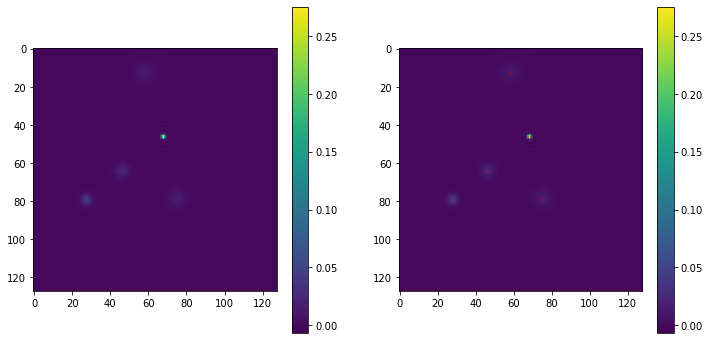

In [ ]:
def pts2img(pts):
    bpos=pts*sz+sz/2
    bposft=bpos*jnp.pi*2
    bposft=bposft[:, :, :, None, None]
    
    ## this is the big 4d matrix for all Gaussian images
    ## (batchsz, # Gaussian, sz, sz//2+1)
    cpxang=idxft[0]*bposft[:,:,0] + idxft[1]*bposft[:,:,1]

    
    ## variable amp
    ## amp should be (sz, sz//2+1)
    pgauss_real=jnp.cos(cpxang)*amp
    pgauss_imag=-jnp.sin(cpxang)*amp
        
    print(f"pgauss_real.shape = {pgauss_real.shape}")
    
    imgs_real=jnp.sum(pgauss_real, axis=1)
    imgs_imag=jnp.sum(pgauss_imag, axis=1)

    return (imgs_real, imgs_imag)


imgs_real, imgs_imag=pts2img(pts00[None,:,:])#.astype(jnp.float32))
print(imgs_real.shape)
#imgs_cpx=np.complex(imgs_real, imgs_imag)
imgs_cpx = imgs_real + 1j*imgs_imag
imgs_out=jnp.fft.irfft2(imgs_cpx)

img0=imgs_out[0]

plt.rcParams["figure.figsize"]=12,6
plt.subplot(1,2,1)
plt.imshow(img0)
plt.colorbar()
p=pts00*sz+sz//2
plt.subplot(1,2,2)
plt.imshow(img0)
plt.colorbar()
plt.plot(p[:,0], p[:,1],'.r', alpha=.2)
plt.rcParams["figure.figsize"]=6,6

### Projection in real space

In [ ]:
def gen_gauss_x(centre, x, sig, sz, amp):
    return jnp.exp(-(x-centre)**2/(2*sig**2)) * max_amp

gen_gauss_x_vmap = jax.vmap(gen_gauss_x, in_axes=(0, None,0,None,None))

def pts2img_one(pts, sigs):
    p_x = gen_gauss_x_vmap(pts[:,0], idx_r, sigs, sz, max_amp)
    p_y = gen_gauss_x_vmap(pts[:,1], idx_r, sigs, sz, max_amp) 
    return jnp.matmul(p_x.transpose(), p_y).transpose()

pts2img_vmap = jax.vmap(pts2img_one, in_axes=(0,0))

Here we approximate the Gaussian in the real domain (it can be found exactly analytically).

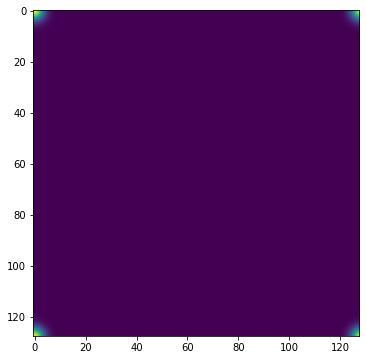

In [12]:
amp_r = jnp.fft.irfft2(amp[0])
amp_rx = amp_r[0]
amp_ry = amp_r[:,0]
plt.imshow(amp_r)
#plt.plot(amp_ry-amp_rx)

0.007587155133523994
0.021953247405972313


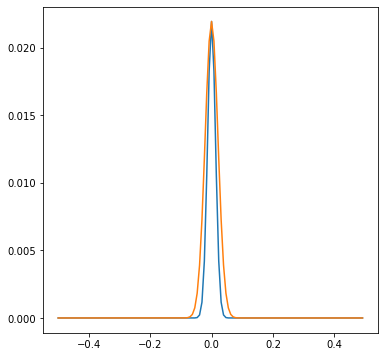

In [13]:
#print(p%pprint00.shape)
idx_r = jnp.arange(-sz/2, sz/2)/sz
#print(idx_r)
sig = 0.0129

sigs = sig + jnp.array(np.random.randn(pts00.shape[0]))*0.01
#sigs = sig * jnp.ones((pts00.shape[0],)) 

centre = 0 #pts00[4,0] #0
max_amp = jnp.max(amp_rx)
gauss_x = gen_gauss_x(idx_r, centre, sig, sz, max_amp)
plt.plot(idx_r,gauss_x)
plt.plot(idx_r, jnp.fft.fftshift(amp_rx))
#plt.plot(jnp.abs(jnp.fft.fftshift(amp_rx)-gauss_x)    )
print(jnp.max(jnp.abs(jnp.fft.fftshift(amp_rx)-gauss_x)))
print(jnp.max(gauss_x))

Generate the image, adjust the scaling so it is the same as in the previous approach, then compare the images.

(128, 128)


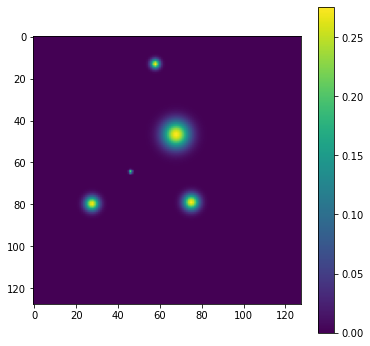

In [14]:
img1 = pts2img_one(pts00, sigs)
img1 = img1/jnp.max(img1)*jnp.max(img0)
print(img1.shape)
plt.imshow(img1);plt.colorbar()

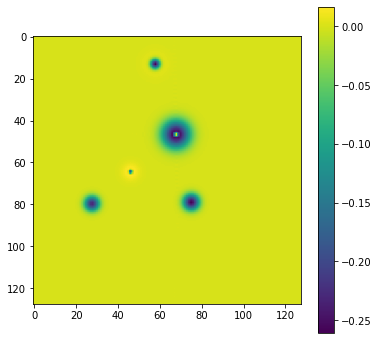

In [15]:
plt.imshow(img0-img1); plt.colorbar()

### Projection in Fourier space, memory-friendly

This implementation replicates the result of the TensorFlow implementation exactly (in single precision)

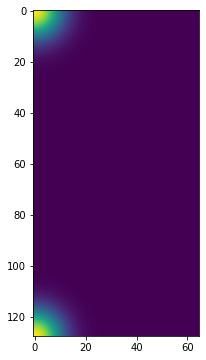

In [16]:
plt.imshow(amp[0])

In [17]:
amp.shape

(5, 128, 65)

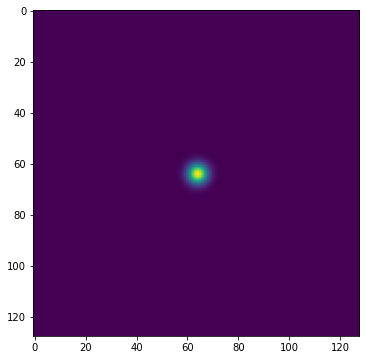

In [18]:
amp_r = jnp.fft.fftshift(jnp.fft.irfft2(amp[0]))
plt.imshow(amp_r)

In [19]:
amp[:,:,0].shape

(5, 128)

In [24]:
def mult_gauss_coords(centre, coords):
    return centre*coords

mult_gauss_coords_vmap = jax.vmap(mult_gauss_coords, in_axes=(0,None))

def pts2img2_one(pts, idxft):
    bpos=pts*sz+sz/2
    bposft=bpos*jnp.pi*2
    
    cpxang_x = mult_gauss_coords_vmap(bposft[:,0], idxft[0,0,:])   # 0 0 :
    cpxang_y = mult_gauss_coords_vmap(bposft[:,1], idxft[1,:,0])   # 1 : 0

    pgauss_x = jnp.exp(-1j*cpxang_x) * amp[:,0,:]
    pgauss_y = jnp.exp(-1j*cpxang_y) * amp[:,:,0]
    
    print(f"pgauss_x.shape = {pgauss_x.shape}")
    print(f"pgauss_y.shape = {pgauss_y.shape}")
  
    pgauss = jnp.matmul(pgauss_x.transpose(), pgauss_y).transpose() #* amp[2]
    
    print(f"pgauss.shape = {pgauss.shape}")
    print(f"amp.shape = {amp.shape}")

    
    return pgauss

pgauss_x.shape = (5, 65)
pgauss_y.shape = (5, 128)
pgauss.shape = (128, 65)
amp.shape = (5, 128, 65)
5.0
60.1302318113929


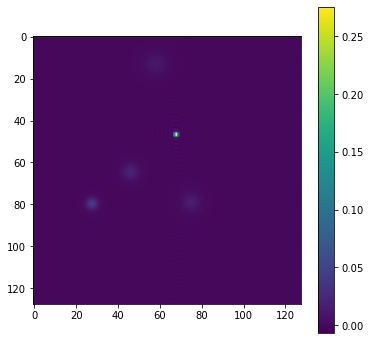

In [25]:
img_cpx2 = pts2img2_one(pts00, idxft[:,0,:,:])
print(jnp.max(jnp.real(img_cpx2)))

img2=jnp.fft.irfft2(img_cpx2)

print(jnp.max(jnp.real(img_cpx2)))

#plt.subplot(1,2,1)
plt.imshow(img2)
plt.colorbar()
#p=pts00*sz+sz//2
#plt.subplot(1,2,2)
#plt.imshow(img)
#plt.plot(p[:,0], p[:,1],'.r', alpha=.2)

Compare the two images

8.631646722891937e-16
0.27563062050931253


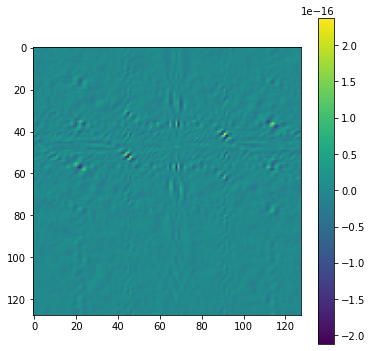

In [26]:
print(jnp.max(jnp.abs(img0-img2)/jnp.max(img0)))
print(jnp.max(img2))
plt.imshow(img0-img2); plt.colorbar()

### Loss functions

A basic squared L2 norm loss function, one for the TensorFlow approach and one for the last approach.

In [ ]:
def loss_func(pts, img_f):
    imgs_real, imgs_imag=pts2img(pts)
    err_real = imgs_real - jnp.real(img_f)
    err_imag = imgs_imag - jnp.imag(img_f)
    return jnp.sum(err_real**2 + err_imag**2)

grad_loss = jax.grad(loss_func)

In [ ]:
def loss_func_one(pts, img_f):
    proj_f = pts2img2_one(pts,idxft[:,0,:,:])
    err = proj_f - img_f
    return jnp.real(jnp.sum(jnp.conj(err)*err))

grad_loss_one = jax.grad(loss_func_one)

loss_func_vmap = jax.vmap(loss_func_one, in_axes = (None,0))

def loss_func_sum(pts, imgs_f):
    return jnp.mean(loss_func_vmap(pts, imgs_f))

def grad_loss_func_sum(pts, imgs_f):
    return jax.grad(loss_func_sum)(pts, imgs_f)

zero_img = jnp.zeros([sz, int(sz/2)+1])

In [ ]:
t0 = time.time()
loss1 = loss_func(pts00[None,:,:], zero_img)
gp1 = grad_loss(pts00[None,:,:], zero_img)
print(time.time()-t0)

In [ ]:
t0 = time.time()
loss2 = loss_func_one(pts00, zero_img )
gp2 = grad_loss_one(pts00, zero_img)
print(time.time()-t0)

The two approaches agree:

In [ ]:
print((loss1-loss2)/jnp.max(jnp.abs(gp1)))
print(jnp.max(jnp.abs(gp1[0]-gp2))/jnp.max(jnp.abs(gp1)))

In [ ]:
loss1

In [ ]:
loss2

### Generate a batch of images to test the performance

In [ ]:
#### make some particle images for training later
##   they should stay in CPU as well
nptcl=1000
ptcls=0.1*np.random.randn(nptcl, sz,sz)+np.array(img2)
plt.imshow(ptcls[13]); plt.colorbar()
ptcls_f=np.fft.rfft2(ptcls)
#ptcls_real=jnp.real(ptcls_cpx).astype(jnp.float64)
#ptcls_imag=jnp.imag(ptcls_cpx).astype(jnp.float64)
print(ptcls_f.shape)

In [ ]:
type(ptcls_f)

In [ ]:
print(jnp.max(img2))
print(jnp.max(ptcls[10]))

In [ ]:
t0 = time.time()
loss2 = loss_func_one(pts00, ptcls_f[10])
gp2 = grad_loss_one(pts00, ptcls_f[10])
print(time.time()-t0)
print(gp2.shape)

Apply the loss and the gradient functions to the batch of 1000 images.

In [ ]:
t0 = time.time()
loss_sum = loss_func_sum(pts00, ptcls_f)
print(time.time() - t0)
print(loss_sum)

In [ ]:
t0 = time.time()
grad_loss = grad_loss_func_sum(pts00, ptcls_f)
print(time.time() - t0)
print(grad_loss.shape)

Jax allocates all the available memory at the beginning, so the following does not tell us much (other than the total available memory, 8GB in this case)

In [ ]:
os.system("nvidia-smi ");

### Gradient descent on the Gaussian locations

In [ ]:
# Sample the initial points in the same way as the correct ones.

p0 = jnp.array(np.random.randn(npt,2))
p0 = p0/(jnp.max(abs(p0))*2.5)

plt.plot(pts00[:,0],pts00[:,1], '.')
plt.plot(p0[:,0],p0[:,1], '.')

In [ ]:
N_iter = 1000
alpha = 1e-7

p = p0
for i in range(N_iter):
    gl = grad_loss_func_sum(p, ptcls_f)
    p = p - alpha * gl
    if jnp.mod(i,50)==0:
        print(i, jnp.linalg.norm(gl,2))


In [ ]:
# Estimated Gaussian locations

plt.plot(pts00[:,0],pts00[:,1], '.')
plt.plot(p[:,0],p[:,1], '.')

In [ ]:
ptcls_f.shape